# Plots and analysis for Monte Carlo ensembles

Corresponds to the main text results, including:
* SSP1-RCP2.6
* SSP2-RCP4.5
* SSP4-RCP6.0
* SSP5-RCP8.5

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import re, os
import matplotlib.pyplot as plt
%matplotlib inline

Set `projdir` on your system, then everything else is defined relative to that. `pwd` will just give the directory that this Jupyter notebook is housed in.

In [4]:
projdir = os.getcwd()
datdir = projdir + "/../ciam-code/output/MonteCarlo"
plotdir = projdir + "/../ciam-code/figures"

If the plot directory `plotdir` doesn't exist, make it.

In [5]:
if not os.path.exists(plotdir):
    os.makedirs(plotdir)
print("Will save plots to ",plotdir)

Will save plots to  /Users/aewsma/codes/CIAM_uncertainty_propagation/work_uncertainty_propagation/../ciam-code/figures


In [61]:
scenarios = [(1,26),(2,45),(4,60),(5,85)]
surge_option = 0
panels = ["a.","b.","c.","d.","e.","f.","g.","h."]

### Initialize some dicts of DataFrames 

Different dict eleemnts correspond to different SSP/RCP scenarios

In [7]:
df05 = {scen : None for scen in scenarios}
df50 = {scen : None for scen in scenarios}
df95 = {scen : None for scen in scenarios}
df05r = {scen : None for scen in scenarios}
df50r = {scen : None for scen in scenarios}
df95r = {scen : None for scen in scenarios}
dfS = {scen : None for scen in scenarios}
dfC = {scen : None for scen in scenarios}
dfSC = {scen : None for scen in scenarios}

## Read Monte Carlo simulation results

### 5th, 50th and 95th percentiles only (single simulations)

If you generate new simulations, you will need to replace these directory paths and/or file names.

Global NPV:

In [8]:
for (ssp,rcp) in scenarios:
    scendir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/"
    df05[(ssp,rcp)] = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p5/CIAM MC1/PostProcessing/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p5.csv")
    df50[(ssp,rcp)] = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p50/CIAM MC1/PostProcessing/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p50.csv")
    df95[(ssp,rcp)] = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p95/CIAM MC1/PostProcessing/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p95.csv")
    

Regional breakdown:

In [9]:
for (ssp,rcp) in scenarios:
    scendir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/"
    df05r[(ssp,rcp)] = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p5/CIAM MC1/PostProcessing/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p5.csv")
    df50r[(ssp,rcp)] = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p50/CIAM MC1/PostProcessing/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p50.csv")
    df95r[(ssp,rcp)] = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p95/CIAM MC1/PostProcessing/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p95.csv")
regions = list(df05r[(1,26)].columns)


Combine:

In [10]:
for (ssp,rcp) in scenarios:
    df05[(ssp,rcp)] = df05[(ssp,rcp)].join(df05r[(ssp,rcp)])
    df50[(ssp,rcp)] = df50[(ssp,rcp)].join(df50r[(ssp,rcp)])
    df95[(ssp,rcp)] = df95[(ssp,rcp)].join(df95r[(ssp,rcp)])

### SLR uncertainty only

In [15]:
for (ssp,rcp) in scenarios:
    slrdir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR/CIAM MC1000/PostProcessing"
    dfS[(ssp,rcp)] = pd.read_csv(slrdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR.csv")


### CIAM socioeconomic parameter uncertainty only

In [16]:
for (ssp,rcp) in scenarios:
    ciamdir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varyCIAM/CIAM MC1000/PostProcessing"
    dfC[(ssp,rcp)] = pd.read_csv(ciamdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varyCIAM.csv")


### Both SLR and CIAM uncertainty

In [17]:
for (ssp,rcp) in scenarios:
    bothdir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM/CIAM MC1000/PostProcessing"
    dfSC[(ssp,rcp)] = pd.read_csv(bothdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv")


### Histogram

KDE version

In [50]:
x = np.linspace(0,12000,500)
kde = {scen : {} for scen in scenarios}
kde_plot = {scen : {} for scen in scenarios}
for scen in scenarios:
    kde[scen]["S"] = stats.gaussian_kde(dfS[scen].npv)
    kde[scen]["C"] = stats.gaussian_kde(dfC[scen].npv)
    kde[scen]["SC"] = stats.gaussian_kde(dfSC[scen].npv)
    for k in kde[scen].keys():
        kde_plot[scen][k] = kde[scen][k](x)

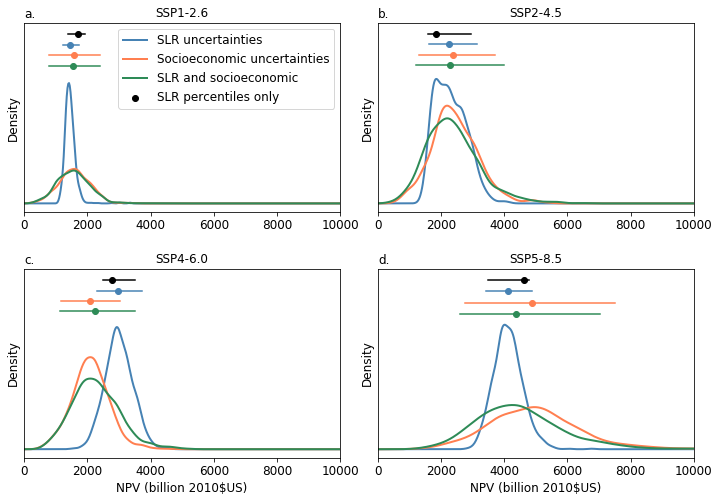

In [78]:
y00 = [0.004,  0.001,  0.0013, 0.0012 ]
dy0 = [0.00025,0.00006,0.00008,0.00008]
titles = ["SSP1-2.6", "SSP2-4.5", "SSP4-6.0", "SSP5-8.5"]
fig, ax = plt.subplots(2,2,figsize=(12,8))
for s in range(4):
    scen = scenarios[s]
    ax[int(s/2)][s%2].plot(x,kde_plot[scen]["S"], linewidth=2, color="steelblue", label="SLR uncertainties")
    ax[int(s/2)][s%2].plot(x,kde_plot[scen]["C"], linewidth=2, color="coral", label="Socioeconomic uncertainties")
    ax[int(s/2)][s%2].plot(x,kde_plot[scen]["SC"], linewidth=2, color="seagreen", label="SLR and socioeconomic")
    y0 = y00[s]; dy = dy0[s]
    ax[int(s/2)][s%2].plot([df05[scen].npv, df95[scen].npv], [y0, y0], color="black"); ax[int(s/2)][s%2].scatter(df50[scen].npv, y0, color="black", label="SLR percentiles only")
    y0 -= dy
    ax[int(s/2)][s%2].plot([dfS[scen].npv.quantile(0.05), dfS[scen].npv.quantile(0.95)], [y0, y0], color="steelblue"); ax[int(s/2)][s%2].scatter(dfS[scen].npv.median(), y0, color="steelblue")
    y0 -= dy
    ax[int(s/2)][s%2].plot([dfC[scen].npv.quantile(0.05), dfC[scen].npv.quantile(0.95)], [y0, y0], color="coral"); ax[int(s/2)][s%2].scatter(dfC[scen].npv.median(), y0, color="coral")
    y0 -= dy
    ax[int(s/2)][s%2].plot([dfSC[scen].npv.quantile(0.05), dfSC[scen].npv.quantile(0.95)], [y0, y0], color="seagreen"); ax[int(s/2)][s%2].scatter(dfSC[scen].npv.median(), y0, color="seagreen")
    if s==2 or s==3:
        ax[int(s/2)][s%2].set_xlabel("NPV (billion 2010$US)", fontsize=12); 
    ax[int(s/2)][s%2].set_ylabel("Density", fontsize=12); ax[int(s/2)][s%2].set_yticks([])
    ax[int(s/2)][s%2].set_xlim([0,10000]); ax[int(s/2)][s%2].set_xticklabels(list(range(0,12000,2000)),fontsize=12)
    if s==0:
        ax[int(s/2)][s%2].legend(fontsize=12, frameon=True)
    ax[int(s/2)][s%2].text(0,y00[s]*1.1,panels[s],fontsize=12)
    ax[int(s/2)][s%2].set_title(titles[s], fontsize=12)
plt.subplots_adjust(hspace=0.3, wspace=0.12)
fig.savefig(plotdir+"/global_damages_ssprcp.pdf", bbox_inches='tight');

In [52]:
print("5th, 50th, 95th, and 95-5th percentiles")
for scen in scenarios:
    print(scen)
    print("Percentiles only:      ",np.transpose(np.round([df05[scen].npv, df50[scen].npv, df95[scen].npv, df95[scen].npv-df05[scen].npv], 2))[0])
    print("SLR-only ensemble:     ",np.round([dfS[scen].npv.quantile(.05), dfS[scen].npv.quantile(.5), dfS[scen].npv.quantile(.95), dfS[scen].npv.quantile(.95)-dfS[scen].npv.quantile(.05)], 2))
    print("CIAM-only ensemble:    ",np.round([dfC[scen].npv.quantile(.05), dfC[scen].npv.quantile(.5), dfC[scen].npv.quantile(.95), dfC[scen].npv.quantile(.95)-dfC[scen].npv.quantile(.05)], 2))
    print("SLR and CIAM ensemble: ",np.round([dfSC[scen].npv.quantile(.05), dfSC[scen].npv.quantile(.5), dfSC[scen].npv.quantile(.95), dfSC[scen].npv.quantile(.95)-dfSC[scen].npv.quantile(.05)], 2))
    

5th, 50th, 95th, and 95-5th percentiles
(1, 26)
Percentiles only:       [1380.57 1694.4  1921.09  540.51]
SLR-only ensemble:      [1232.88 1434.41 1719.22  486.34]
CIAM-only ensemble:     [ 794.98 1582.72 2412.12 1617.15]
SLR and CIAM ensemble:  [ 776.42 1538.12 2393.34 1616.92]
(2, 45)
Percentiles only:       [1586.25 1844.03 2942.48 1356.23]
SLR-only ensemble:      [1627.18 2259.23 3143.38 1516.19]
CIAM-only ensemble:     [1314.9  2381.19 3710.14 2395.24]
SLR and CIAM ensemble:  [1197.03 2287.98 3987.95 2790.92]
(4, 60)
Percentiles only:       [2481.69 2791.72 3516.12 1034.43]
SLR-only ensemble:      [2289.39 2985.02 3722.04 1432.64]
CIAM-only ensemble:     [1149.52 2087.66 3030.07 1880.55]
SLR and CIAM ensemble:  [1140.09 2227.15 3508.64 2368.55]
(5, 85)
Percentiles only:       [3485.51 4618.52 4777.6  1292.09]
SLR-only ensemble:      [3407.17 4108.21 4884.8  1477.63]
CIAM-only ensemble:     [2761.58 4882.41 7502.46 4740.88]
SLR and CIAM ensemble:  [2586.72 4368.23 7045.79 4459.07]


#### Numbers for the paper

In [49]:
scen = (5,85)
print("Percent increases in median:")
print("tight coupling relative to percentiles:",np.round(float(100*(dfSC[scen].npv.quantile(.5)-df50[scen].npv)/df50[scen].npv),2))
print("tight coupling relative to CIAM-only:  ",np.round(100*(dfSC[scen].npv.quantile(.5)-dfC[scen].npv.quantile(.5))/dfC[scen].npv.quantile(.5),2))
print("\nPercent increases in 95th percentile:")
print("tight coupling relative to percentiles:",np.round(float(100*(dfSC[scen].npv.quantile(.95)-df95[scen].npv)/df95[scen].npv),2))
print("tight coupling relative to CIAM-only:  ",np.round(100*(dfSC[scen].npv.quantile(.95)-dfC[scen].npv.quantile(.95))/dfC[scen].npv.quantile(.95),2))

Percent increases in median:
tight coupling relative to percentiles: -5.42
tight coupling relative to CIAM-only:   -10.53

Percent increases in 95th percentile:
tight coupling relative to percentiles: 47.48
tight coupling relative to CIAM-only:   -6.09


<h1 style="color:firebrick;font-size:40pt">HERE NOW</h1>

### Write to CSV file for Supplemental Material

In [14]:
percentiles_out = [0,0.01,0.025,0.05,0.17,0.25,0.5,0.75,0.83,0.95,0.975,0.99,1]
dfOut = pd.DataFrame(data={"percentile" : percentiles_out,
                           "percentiles-only" : [np.nan,np.nan,np.nan,df05.npv[0],np.nan,np.nan,df50.npv[0],np.nan,np.nan,df95.npv[0],np.nan,np.nan,np.nan],
                           "SLR-only" : dfS.npv.quantile(percentiles_out),
                           "CIAM-only" : dfC.npv.quantile(percentiles_out),
                           "SLR and CIAM" : dfSC.npv.quantile(percentiles_out)
                          })
filename_out = datdir+"/FigureData_global_totalNPV_ensembles_SSP5-RCP85.csv"
dfOut.to_csv(filename_out, index=False)
print(dfOut)

       percentile  percentiles-only     SLR-only     CIAM-only  SLR and CIAM
0.000       0.000               NaN  2801.377512   1538.088448   1709.115962
0.010       0.010               NaN  3130.554728   1980.117460   2153.841409
0.025       0.025               NaN  3281.822694   2304.902187   2366.279504
0.050       0.050       3769.664644  3425.290454   2468.207104   2606.089408
0.170       0.170               NaN  3744.141335   3316.094979   3345.905608
0.250       0.250               NaN  3912.587593   3663.418576   3710.415776
0.500       0.500       4085.218339  4323.956167   4393.495378   4688.849229
0.750       0.750               NaN  4720.108983   5227.447185   5597.489490
0.830       0.830               NaN  4923.285205   5589.372016   6023.916505
0.950       0.950       5623.944269  5364.136038   6750.851452   7363.408019
0.975       0.975               NaN  5623.217906   7447.121220   8065.241548
0.990       0.990               NaN  5818.424119   8704.368601   8896.090791

## Aggregate by World Bank region (7 of them) and compute total NPV as %GDP (2010)

### GDP per capita

Grabbing just the first year (2010). All in US$2010.

In [15]:
ypcc = pd.read_csv(projdir+"/../ciam-code/data/ssp/ypcc_IIASAGDP_SSP5_v9_130219.csv")
dfGP = pd.DataFrame()
dfGP["rgn"] = ypcc.columns[1:]
dfGP["gdp_per_capita"] = np.array(ypcc.iloc[0][1:])

### population (millions)

In [16]:
pop = pd.read_csv(projdir+"/../ciam-code/data/ssp/pop_IIASAGDP_SSP5_v9_130219.csv")
dfGP["pop"] = np.array(pop.iloc[0][1:])

### get total GDP

In [17]:
dfGP["gdp"] = dfGP["gdp_per_capita"]*dfGP["pop"]*1e6/1e9 
# 1e6 since population is in units of millions
# and /1e9 to get in units of billions US$2010

### mapping of segments/regions in CIAM, to the 7 World Bank regions

gdp is in units of billions US$2010, since hte NPV results are also billions

In [18]:
wbsegs = pd.read_csv(projdir+"/../ciam-code/data/segments_regions_WB.csv")
regions = list(wbsegs["global region"].unique())
rgn_gdp = {}
for rgn in regions:
    rgns_this_rgn = wbsegs.loc[wbsegs["global region"]==rgn, "regions"].unique()
    rgn_gdp[rgn] = dfGP.loc[dfGP["rgn"].isin(rgns_this_rgn),"gdp"].sum()

Check:

In [19]:
print(rgn_gdp)

{'Europe and Central Asia': 18966.976402719152, 'Middle East and North Africa': 3938.501973598944, 'Sub-Saharan Africa': 1362.4469249975007, 'Latin America and the Caribbean': 6594.935674050595, 'East Asia and Pacific': 23439.597988189, 'South Asia': 5258.98316979206, 'North America': 15789.464594560679}


### compute the NPV as %GDP (in 2010)

In [20]:
for rgn in regions:
    dfS["npv/gpd "+rgn] = 100*dfS[rgn]/rgn_gdp[rgn]
    dfC["npv/gpd "+rgn] = 100*dfC[rgn]/rgn_gdp[rgn]
    dfSC["npv/gpd "+rgn] = 100*dfSC[rgn]/rgn_gdp[rgn]

world NPV as %GDP

In [21]:
dfS["npv/gpd"] = 100*dfS["npv"]/np.sum(list(rgn_gdp.values()))
dfC["npv/gpd"] = 100*dfC["npv"]/np.sum(list(rgn_gdp.values()))
dfSC["npv/gpd"] = 100*dfSC["npv"]/np.sum(list(rgn_gdp.values()))

<br>

# Density estimates for each region

<br>

In [22]:
kde = {}
kde["S"] = {}; kde["C"] = {}; kde["SC"] = {}
kde["S"]["World"] = stats.gaussian_kde(dfS["npv/gpd"])
kde["C"]["World"] = stats.gaussian_kde(dfC["npv/gpd"])
kde["SC"]["World"] = stats.gaussian_kde(dfSC["npv/gpd"])
for rgn in regions:
    kde["S"][rgn] = stats.gaussian_kde(dfS["npv/gpd "+rgn])
    kde["C"][rgn] = stats.gaussian_kde(dfC["npv/gpd "+rgn])
    kde["SC"][rgn] = stats.gaussian_kde(dfSC["npv/gpd "+rgn])
    
x = np.linspace(0,15,200)
kde_plot = {}
kde_plot["S"] = {}; kde_plot["C"] = {}; kde_plot["SC"] = {}
kde_plot["S"]["World"] = kde["S"]["World"](x)
kde_plot["C"]["World"] = kde["C"]["World"](x)
kde_plot["SC"]["World"] = kde["SC"]["World"](x)
for rgn in regions:
    kde_plot["S"][rgn] = kde["S"][rgn](x)
    kde_plot["C"][rgn] = kde["C"][rgn](x)
    kde_plot["SC"][rgn] = kde["SC"][rgn](x)

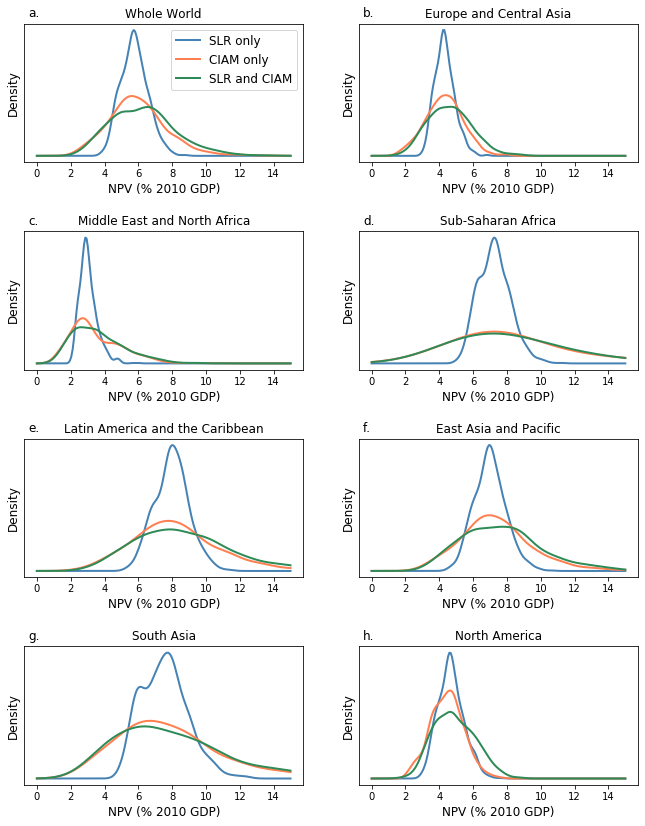

In [23]:
# from above

fig, ax = plt.subplots(4,2,figsize=(11,14))
fig.subplots_adjust(hspace=.5)
bins = range(0,20,1)
panels = ["a.","b.","c.","d.","e.","f.","g.","h."]

# whole world
rgn = "World"
pan = 0
ax[0][0].plot(x, kde_plot["S"][rgn], linewidth=2, color="steelblue", label="SLR only")
ax[0][0].plot(x, kde_plot["C"][rgn], linewidth=2, color="coral", label="CIAM only")
ax[0][0].plot(x, kde_plot["SC"][rgn], linewidth=2, color="seagreen", label="SLR and CIAM")
ax[0][0].set_xlabel("NPV (% 2010 GDP)", fontsize=12)
ax[0][0].set_ylabel("Density", fontsize=12); ax[0][0].set_yticks([])
ax[0][0].legend(fontsize=12, frameon=True)
ax[0][0].set_title("Whole World")
#ylims = ax[0][0].get_ylim(); top = ylims[1]+.05*(ylims[1]-ylims[0]); ax[0][0].text(-0.5,top,"a.", fontsize=12)
ylims = ax[0][0].get_ylim(); top = ylims[1]*1.05; ax[0][0].text(-0.5,top, panels[pan], fontsize=12);

# regions
rgn = regions[0]
pan += 1
ax[0][1].plot(x, kde_plot["S"][rgn], linewidth=2, color="steelblue", label="SLR only")
ax[0][1].plot(x, kde_plot["C"][rgn], linewidth=2, color="coral", label="CIAM only")
ax[0][1].plot(x, kde_plot["SC"][rgn], linewidth=2, color="seagreen", label="SLR and CIAM")
ax[0][1].set_xlabel("NPV (% 2010 GDP)", fontsize=12)
ax[0][1].set_ylabel("Density", fontsize=12); ax[0][1].set_yticks([])
ax[0][1].set_title(rgn)
ylims = ax[0][1].get_ylim(); top = ylims[1]*1.05; ax[0][1].text(-0.5,top, panels[pan], fontsize=12);

ir = 1
for row in range(1,4):
    for col in range(2):
        rgn = regions[ir]
        ir += 1
        pan += 1
        ax[row][col].plot(x, kde_plot["S"][rgn], linewidth=2, color="steelblue", label="SLR only")
        ax[row][col].plot(x, kde_plot["C"][rgn], linewidth=2, color="coral", label="CIAM only")
        ax[row][col].plot(x, kde_plot["SC"][rgn], linewidth=2, color="seagreen", label="SLR and CIAM")
        ax[row][col].set_xlabel("NPV (% 2010 GDP)", fontsize=12)
        ax[row][col].set_ylabel("Density", fontsize=12); ax[row][col].set_yticks([])
        ax[row][col].set_title(rgn)
        ylims = ax[row][col].get_ylim(); top = ylims[1]*1.05; ax[row][col].text(-0.5,top, panels[pan], fontsize=12);

fig.savefig(plotdir+"/regional_damages_ssp5-rcp85.pdf", bbox_inches='tight')

Regional numbers

In [29]:
print("5th, 50th, 95th, and 95-5th percentiles")
print("====================================================")
print("World")
print("SLR-only ensemble:     ",np.round([dfS["npv/gpd"].quantile(.05), dfS["npv/gpd"].quantile(.5), dfS["npv/gpd"].quantile(.95), dfS["npv/gpd"].quantile(.95)-dfS["npv/gpd"].quantile(.05)], 2))
print("CIAM-only ensemble:    ",np.round([dfC["npv/gpd"].quantile(.05), dfC["npv/gpd"].quantile(.5), dfC["npv/gpd"].quantile(.95), dfC["npv/gpd"].quantile(.95)-dfC["npv/gpd"].quantile(.05)], 2))
print("SLR and CIAM ensemble: ",np.round([dfSC["npv/gpd"].quantile(.05), dfSC["npv/gpd"].quantile(.5), dfSC["npv/gpd"].quantile(.95), dfSC["npv/gpd"].quantile(.95)-dfSC["npv/gpd"].quantile(.05)], 2))
for rgn in regions:
    print("====================================================")
    print(rgn)
    print("SLR-only ensemble:     ",np.round([dfS["npv/gpd "+rgn].quantile(.05), dfS["npv/gpd "+rgn].quantile(.5), dfS["npv/gpd "+rgn].quantile(.95), dfS["npv/gpd "+rgn].quantile(.95)-dfS["npv/gpd "+rgn].quantile(.05)], 2))
    print("CIAM-only ensemble:    ",np.round([dfC["npv/gpd "+rgn].quantile(.05), dfC["npv/gpd "+rgn].quantile(.5), dfC["npv/gpd "+rgn].quantile(.95), dfC["npv/gpd "+rgn].quantile(.95)-dfC["npv/gpd "+rgn].quantile(.05)], 2))
    print("SLR and CIAM ensemble: ",np.round([dfSC["npv/gpd "+rgn].quantile(.05), dfSC["npv/gpd "+rgn].quantile(.5), dfSC["npv/gpd "+rgn].quantile(.95), dfSC["npv/gpd "+rgn].quantile(.95)-dfSC["npv/gpd "+rgn].quantile(.05)], 2))

5th, 50th, 95th, and 95-5th percentiles
World
SLR-only ensemble:      [4.55 5.74 7.12 2.57]
CIAM-only ensemble:     [3.28 5.83 8.96 5.68]
SLR and CIAM ensemble:  [3.46 6.22 9.77 6.31]
Europe and Central Asia
SLR-only ensemble:      [3.47 4.28 5.38 1.92]
CIAM-only ensemble:     [2.41 4.31 6.14 3.73]
SLR and CIAM ensemble:  [2.65 4.6  6.79 4.14]
Middle East and North Africa
SLR-only ensemble:      [2.35 2.95 4.04 1.69]
CIAM-only ensemble:     [1.5  3.09 6.32 4.82]
SLR and CIAM ensemble:  [1.62 3.39 6.57 4.94]
Sub-Saharan Africa
SLR-only ensemble:      [5.82 7.22 8.89 3.07]
CIAM-only ensemble:     [ 3.8   7.86 20.15 16.35]
SLR and CIAM ensemble:  [ 3.82  7.97 23.66 19.84]
Latin America and the Caribbean
SLR-only ensemble:      [6.31 7.99 9.7  3.39]
CIAM-only ensemble:     [ 4.37  7.99 13.17  8.79]
SLR and CIAM ensemble:  [ 4.55  8.32 14.4   9.85]
East Asia and Pacific
SLR-only ensemble:      [5.53 6.97 8.61 3.09]
CIAM-only ensemble:     [ 4.13  7.22 11.33  7.2 ]
SLR and CIAM ensemble:  [ 

### Write to CSV files for Supplemental Material

First, as percent of regional GDP

In [30]:
percentiles_out = [0,0.01,0.025,0.05,0.17,0.25,0.5,0.75,0.83,0.95,0.975,0.99,1]

rgn_dict = {"percentile" : percentiles_out}
for rgn in regions:
    rgn_dict["SLR-only "+rgn] = dfS["npv/gpd "+rgn].quantile(percentiles_out)
    rgn_dict["CIAM-only "+rgn] = dfC["npv/gpd "+rgn].quantile(percentiles_out)
    rgn_dict["SLR and CIAM "+rgn] = dfSC["npv/gpd "+rgn].quantile(percentiles_out)
dfOut = pd.DataFrame(data=rgn_dict)

filename_out = datdir+"/FigureData_regional_percentGDP_ensembles_SSP5-RCP85.csv"
dfOut.to_csv(filename_out, index=False)
print(dfOut)

       percentile  SLR-only Europe and Central Asia  \
0.000       0.000                          2.952676   
0.010       0.010                          3.226830   
0.025       0.025                          3.319424   
0.050       0.050                          3.465107   
0.170       0.170                          3.753086   
0.250       0.250                          3.911232   
0.500       0.500                          4.279651   
0.750       0.750                          4.678159   
0.830       0.830                          4.864444   
0.950       0.950                          5.384976   
0.975       0.975                          5.577997   
0.990       0.990                          5.907693   
1.000       1.000                          6.810567   

       CIAM-only Europe and Central Asia  \
0.000                           1.471440   
0.010                           1.867414   
0.025                           2.096350   
0.050                           2.413555   
0.170    

Now as actual NPV

In [31]:
percentiles_out = [0,0.01,0.025,0.05,0.17,0.25,0.5,0.75,0.83,0.95,0.975,0.99,1]

rgn_dict = {"percentile" : percentiles_out}
for rgn in regions:
    rgn_dict["SLR-only "+rgn] = dfS[rgn].quantile(percentiles_out)
    rgn_dict["CIAM-only "+rgn] = dfC[rgn].quantile(percentiles_out)
    rgn_dict["SLR and CIAM "+rgn] = dfSC[rgn].quantile(percentiles_out)
dfOut = pd.DataFrame(data=rgn_dict)

filename_out = datdir+"/FigureData_regional_totalNPV_ensembles_SSP5-RCP85.csv"
dfOut.to_csv(filename_out, index=False)
print(dfOut)

       percentile  SLR-only Europe and Central Asia  \
0.000       0.000                        560.033388   
0.010       0.010                        612.032052   
0.025       0.025                        629.594429   
0.050       0.050                        657.226046   
0.170       0.170                        711.846996   
0.250       0.250                        741.842405   
0.500       0.500                        811.720315   
0.750       0.750                        887.305272   
0.830       0.830                        922.637975   
0.950       0.950                       1021.367099   
0.975       0.975                       1057.977439   
0.990       0.990                       1120.510668   
1.000       1.000                       1291.758668   

       CIAM-only Europe and Central Asia  \
0.000                         279.087587   
0.010                         354.191916   
0.025                         397.614296   
0.050                         457.778323   
0.170    

# Same global and regional analysis, but for SSP1-RCP2.6

In separate Jupyter notebook - `plotsAndAnalysis_uncertaintyPropagation_SSP1-RCP26.ipynb`.

## Check quantiles as sample size changes

Using SSP2-RCP4.5.

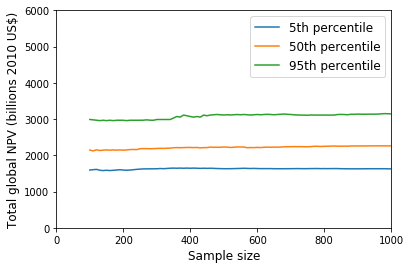

In [47]:
sample_sizes = np.arange(start=100,stop=1100,step=10)
quantiles = np.zeros((len(sample_sizes),3))
for ii in range(len(sample_sizes)):
    quantiles[ii,0] = dfS[(2,45)][:sample_sizes[ii]]["npv"].quantile(.05)
    quantiles[ii,1] = dfS[(2,45)][:sample_sizes[ii]]["npv"].quantile(.5)
    quantiles[ii,2] = dfS[(2,45)][:sample_sizes[ii]]["npv"].quantile(.95)

fig, ax = plt.subplots(1,1,figsize=(6,4))
plt.plot(sample_sizes, quantiles[:,0], label="5th percentile")
plt.plot(sample_sizes, quantiles[:,1], label="50th percentile")
plt.plot(sample_sizes, quantiles[:,2], label="95th percentile")
plt.xlim([0,1000]); plt.ylim([0,6000])
plt.xlabel("Sample size", fontsize=12); plt.ylabel("Total global NPV (billions 2010 US$)", fontsize=12)
plt.legend(loc="best", fontsize=12)
fig.savefig(plotdir+"/quantiles_sample_size.pdf", bbox_inches='tight');